In [43]:
import pandas as pd
import numpy as np

import sys
import pandas as pd

if ".." not in sys.path:
    sys.path.append("..")

from scipy.stats import anderson

norte2 = pd.read_csv("../processed_datasets/NORTE2_2021_2023.csv", parse_dates=["date"])
noroeste2 = pd.read_csv(
    "../processed_datasets/NOROESTE2_2021_2023.csv", parse_dates=["date"]
)
sureste3 = pd.read_csv(
    "../processed_datasets/SURESTE3_2021_2023.csv", parse_dates=["date"]
)
import seaborn as sns
from utils import hist_plot

norte2.head()

,date,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
0,2021-03-01 01:00:00,2.30,6.7,19.2,21.8,16.0,NaN,2.0,709.4,0.0,57.0,1.1,0.0,24.80,5.3,93.0
1,2021-03-01 02:00:00,2.30,11.5,19.6,27.1,9.0,NaN,NaN,709.4,0.0,61.0,NaN,0.0,23.91,5.7,43.0
2,2021-03-01 03:00:00,2.30,9.7,26.0,31.7,4.0,NaN,NaN,709.2,0.0,65.0,NaN,0.0,23.11,2.6,322.0
3,2021-03-01 04:00:00,2.32,15.1,25.4,36.5,3.0,NaN,NaN,709.2,0.0,66.0,NaN,0.0,22.43,1.6,297.0
4,2021-03-01 05:00:00,2.30,18.8,23.3,38.1,3.0,NaN,NaN,709.3,0.0,68.0,NaN,0.0,21.73,1.6,151.0


In [44]:
# Rango de fechas desde 1 marzo 2022 hasta 17 agosto de 2023
date_range = (
    pd.date_range("03/01/2021 01:00:00 a. m.", "17/08/2023  11:00:00 p. m.", freq="h")
    .to_series()
    .reset_index(drop=True)
)

date_range.name = "date"
date_range = date_range.to_frame()
date_range

,date
0,2021-03-01 01:00:00
1,2021-03-01 02:00:00
2,2021-03-01 03:00:00
3,2021-03-01 04:00:00
4,2021-03-01 05:00:00
...,...
21594,2023-08-17 19:00:00
21595,2023-08-17 20:00:00
21596,2023-08-17 21:00:00
21597,2023-08-17 22:00:00


In [45]:
def imputar_fechas(df: pd.DataFrame):
    date_range = (
        pd.date_range(
            "03/01/2021 01:00:00 a. m.", "17/08/2023  11:00:00 p. m.", freq="h"
        )
        .to_series()
        .reset_index(drop=True)
    )

    date_range.name = "date"
    date_range = date_range.to_frame()

    print(date_range.loc[~date_range["date"].isin(df["date"])])

    # Se imputan las fechas que faltan en el dataset con valores nulos para después llenarlos
    return pd.merge(
        df,
        date_range.loc[~date_range["date"].isin(df["date"])],
        on="date",
        how="outer",
    ).sort_values("date")

In [46]:
norte2 = imputar_fechas(norte2)
noroeste2 = imputar_fechas(noroeste2)
sureste3 = imputar_fechas(sureste3)

                     date
1184  2021-04-19 09:00:00
17106 2023-02-11 19:00:00
                     date
1184  2021-04-19 09:00:00
17106 2023-02-11 19:00:00
                     date
1184  2021-04-19 09:00:00
17106 2023-02-11 19:00:00


In [47]:
print(norte2.describe())
print(noroeste2.describe())
print(sureste3.describe())

                      date            CO            NO           NO2  \
count                21599  21414.000000  21020.000000  21015.000000   
mean   2022-05-25 00:00:00      1.130664     19.221346     20.109170   
min    2021-03-01 01:00:00      0.170000      0.600000      0.400000   
25%    2021-10-12 00:30:00      0.840000      4.900000     11.400000   
50%    2022-05-25 00:00:00      1.050000      9.000000     16.500000   
75%    2023-01-04 23:30:00      1.350000     23.100000     25.700000   
max    2023-08-17 23:00:00     13.790000    365.500000    113.300000   
std                    NaN      0.452435     24.782472     12.227742   

                NOX            O3          PM10         PM2.5           PRS  \
count  21016.000000  21134.000000  21154.000000  19996.000000  21392.000000   
mean      38.884045     24.562317     70.287652     20.235297    712.728081   
min        1.400000      1.000000      2.000000      1.000000    680.800000   
25%       17.500000     12.000000  

In [48]:
def Imputacion_datos(datos: pd.DataFrame, columna: str) -> pd.DataFrame:
    try:
        datos["Datos anteriores"] = datos[columna].ffill()
    except:
        datos["Datos anteriores"] = datos[columna].bfill()
    datos["Datos siguientes"] = datos[columna].bfill()

    datos["Promedio"] = datos[["Datos anteriores", "Datos siguientes"]].mean(axis=1)

    return datos["Promedio"]

In [49]:
def Imputar_datos(datos):
    df = datos.copy()
    for variable in datos.drop(["date"], axis=1).columns:
        df[variable] = Imputacion_datos(datos, variable)
    return df

In [50]:
norte2 = Imputar_datos(norte2)
noroeste2 = Imputar_datos(noroeste2)
sureste3 = Imputar_datos(sureste3)

In [51]:
# norte2[norte2.columns[1:]] = norte2[norte2.columns[1:]].apply(lambda x: x[np.abs(x - x.mean()) <= (3*x.std())])
# noroeste2[noroeste2.columns[1:]] = noroeste2[noroeste2.columns[1:]].apply(lambda x: x[np.abs(x - x.mean()) <= (3*x.std())])
# sureste3[sureste3.columns[1:]] = sureste3[sureste3.columns[1:]].apply(lambda x: x[np.abs(x - x.mean()) <= (3*x.std())])

In [52]:
norte2.isna().sum()

date     0
CO       0
NO       0
NO2      0
NOX      0
O3       0
PM10     0
PM2.5    0
PRS      0
RAINF    0
RH       0
SO2      0
SR       0
TOUT     0
WSR      0
WDR      0
dtype: int64

In [53]:
print(norte2.describe())
print(noroeste2.describe())
print(sureste3.describe())

                      date           CO            NO           NO2  \
count                21599  21599.00000  21599.000000  21599.000000   
mean   2022-05-25 00:00:00      1.13247     18.875888     19.901785   
min    2021-03-01 01:00:00      0.17000      0.600000      0.400000   
25%    2021-10-12 00:30:00      0.84000      4.800000     11.300000   
50%    2022-05-25 00:00:00      1.05000      8.700000     16.200000   
75%    2023-01-04 23:30:00      1.35000     22.600000     25.500000   
max    2023-08-17 23:00:00     13.79000    365.500000    113.300000   
std                    NaN      0.45660     24.577439     12.173707   

                NOX            O3          PM10         PM2.5           PRS  \
count  21599.000000  21599.000000  21599.000000  21599.000000  21599.000000   
mean      38.310632     24.398491     70.355618     19.686444    712.713917   
min        1.400000      1.000000      2.000000      1.000000    680.800000   
25%       17.100000     12.000000     43.000

In [54]:
norte2.to_csv("../non_atypical_datasets/NORTE2_2021_2023.csv", index=False)
noroeste2.to_csv("../non_atypical_datasets/NOROESTE2_2021_2023.csv", index=False)
sureste3.to_csv("../non_atypical_datasets/SURESTE3_2021_2023.csv", index=False)

c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:111

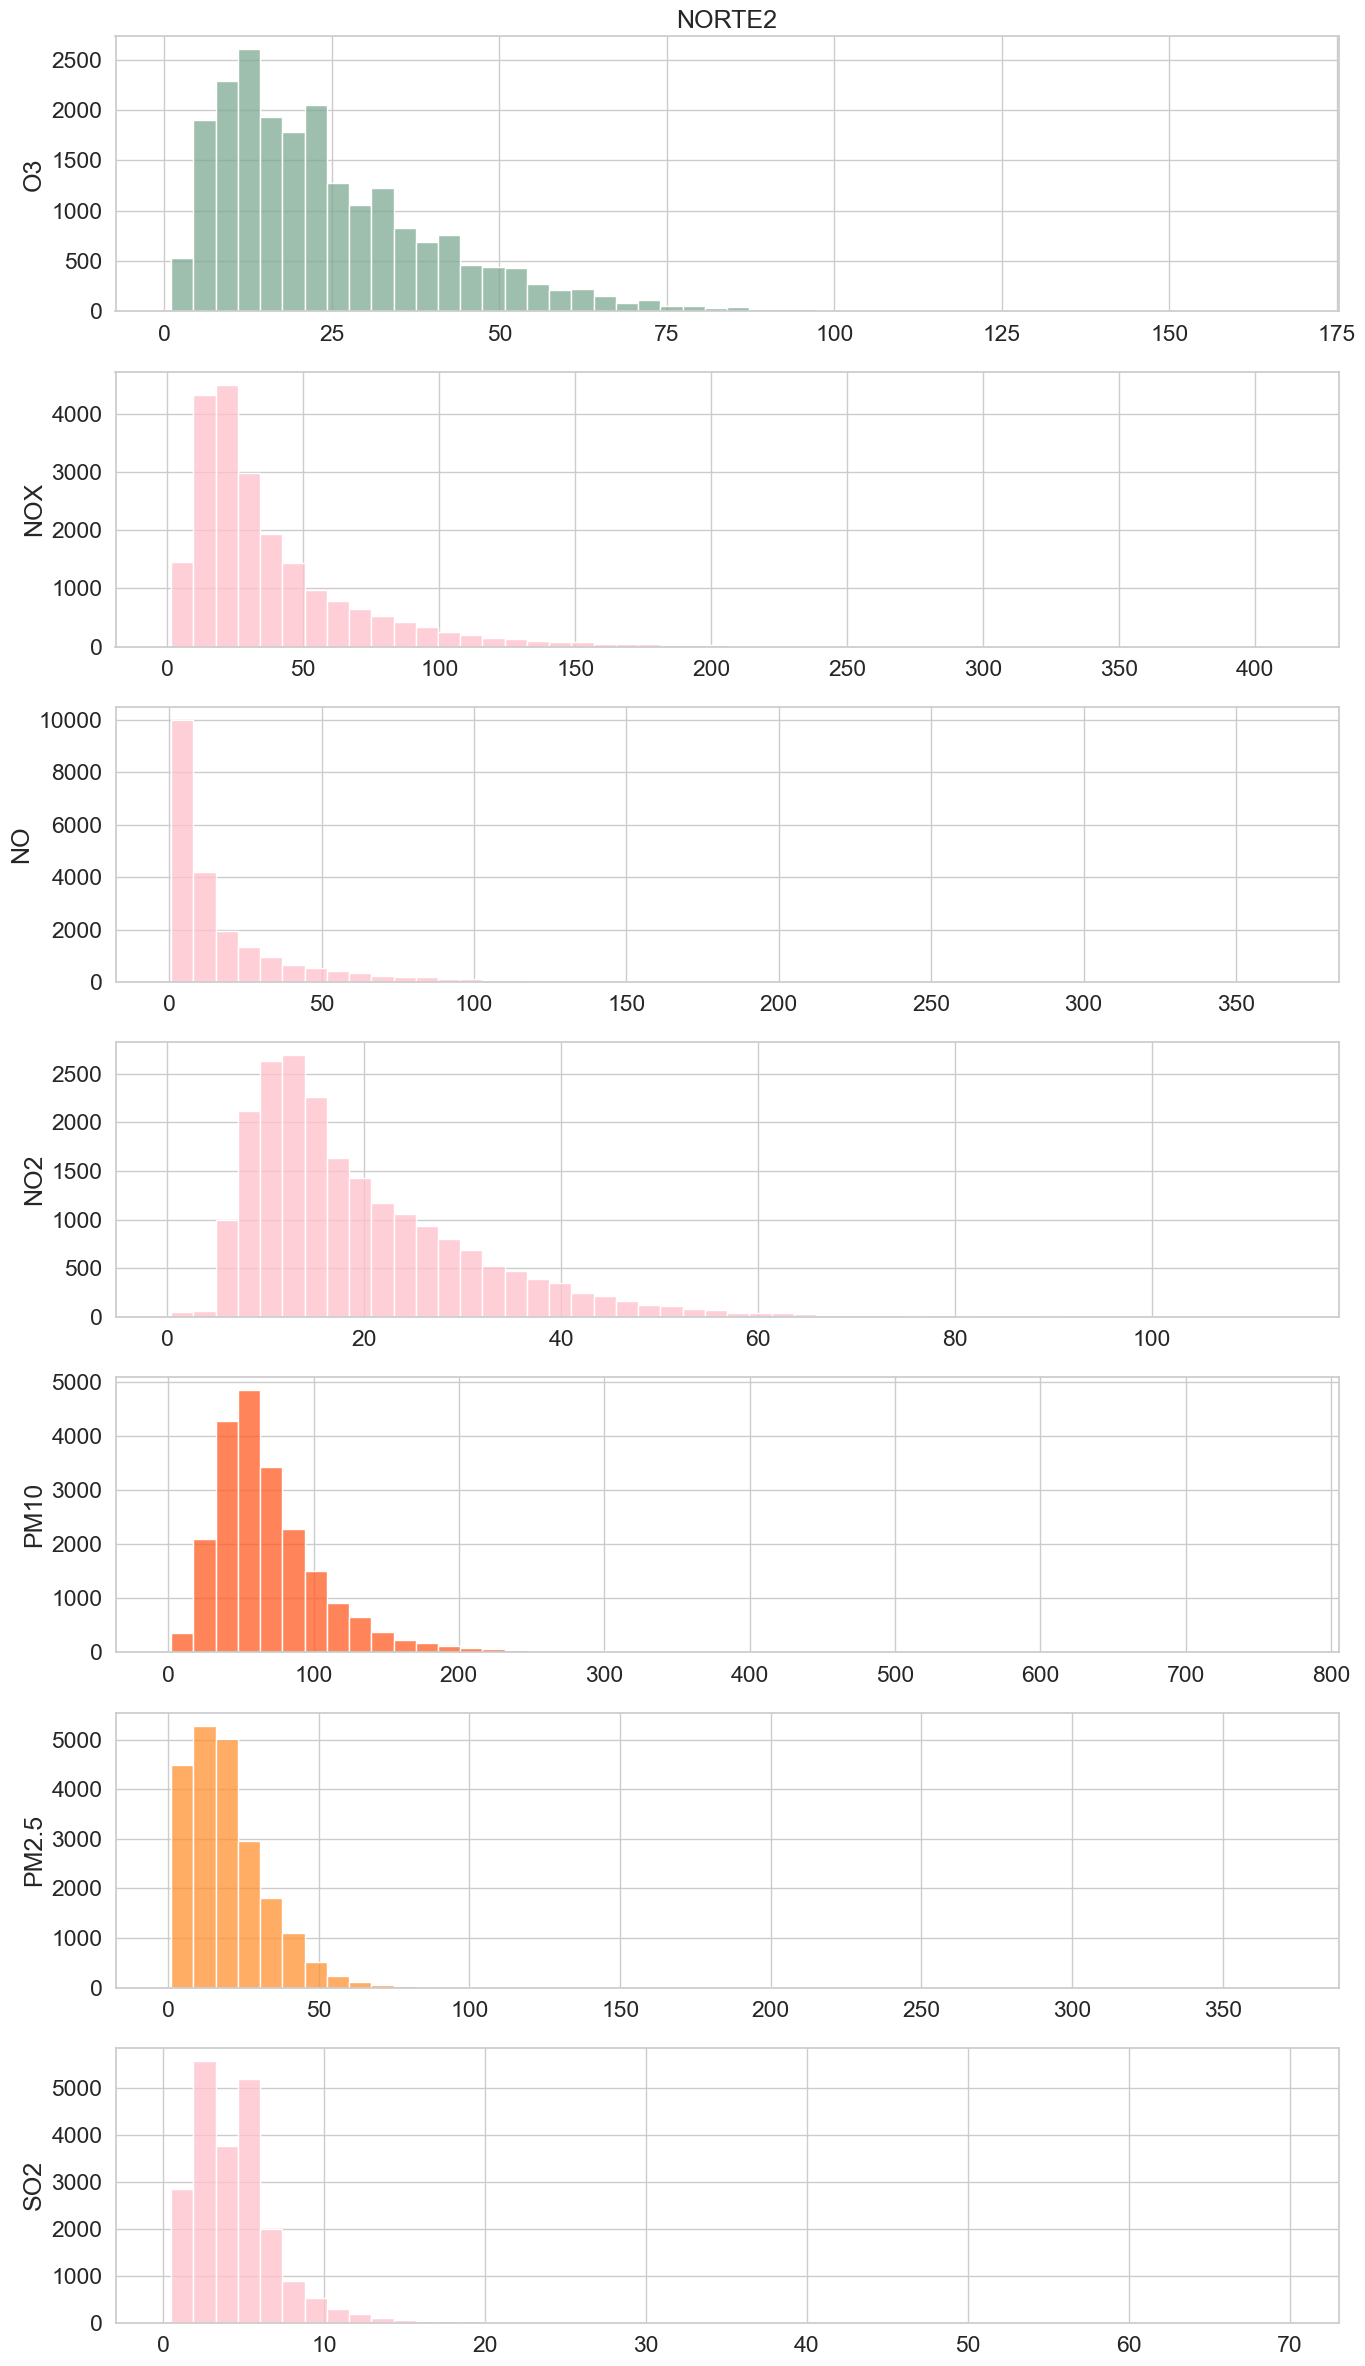

In [55]:
hist_plot(norte2, ["date", "O3", "NOX", "NO", "NO2", "PM10", "PM2.5", "SO2"], "NORTE2")